In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import random
import yahoofinancials as yf
import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# TODO: add proxy servers, else, you will get banned by the hosters for scraping

# Known issues for onvista
# - isin/wkn do not work, freetext can be imprecise, need stronger filters

In [2]:
def preprocess_price_targets(data, valid_days=60, roll_days=5):
    """
    Sampling function for the price targets taking the validity
    of the analysts' opinion into account.
    """
    def simple_sampler(datestr, rn, return_str=True):
        if type(datestr) == datetime.date:
            dt = datestr + datetime.timedelta(days=int(rn))
        elif type(datestr) == str:
            dt = datetime.datetime.strptime(datestr, '%Y-%m-%d') + \
                 datetime.timedelta(days=int(rn))
        if return_str:
            return dt.strftime('%Y-%m-%d')
        return dt
    
    results = []
    tmp = data.copy()
    tmp.sort_values(['dates'], inplace=True)
    for analyst in tmp['analyst'].unique():
        x = tmp.loc[tmp['analyst']==analyst, ['dates', 'analyst', 
                                              'price_target']]
        y = tmp.loc[tmp['analyst']==analyst, 'dates'].diff(
        ).dt.days.shift(-1, fill_value=valid_days)
        results.append(pd.concat([x, y], axis=1))
    results = pd.concat(results)
    results.columns = ['dates', 'analyst', 'price_target', 'validity_days']
    results['validity_days'] = results['validity_days'].astype('int')
    results.sort_values(['dates'], inplace=True)
    results = results.loc[results['price_target'].notna(), :]
    
    sampled = []
    for row in range(len(results)):
        np.random.seed(row**2)
        sampled.append(pd.DataFrame([(
            simple_sampler(results['dates'].astype('str').values[row], rn), 
            results['price_target'].iloc[row]) 
                  for rn in range(results['validity_days'].iloc[row])])
        )

    sampled = pd.concat(sampled)
    sampled.columns = ['dates', 'price_target']
    sampled['dates'] = pd.to_datetime(sampled['dates'])
    sampled = sampled.groupby(['dates']).agg({'price_target': 'mean'}
                                        ).sort_values(['dates'])
    sampled['rolling_mean'] = sampled['price_target'].rolling(roll_days, 
                                            center=True).mean()
    sampled['rolling_std'] = sampled['price_target'].rolling(roll_days, 
                                            center=True).std()
    sampled.reset_index(inplace=True)
    return sampled

def load_stock_data(idxs, start='2010-01-01', end='2020-06-01',
                    interval='daily'):
    data = yf.YahooFinancials(idxs)
    data = data.get_historical_price_data(start_date=start, 
                                          end_date=end, 
                                          time_interval=interval)
    df = []
    for col in idxs:
        tmp = pd.DataFrame(data[col]['prices'])
        tmp['stockname'] = col
        try:
            tmp['currency'] = data[col]['currency']
        except:
            tmp['currency'] = ''
        df.append(tmp)
    df = pd.concat(df)
    df['formatted_date'] = pd.to_datetime(df['formatted_date'], 
                                        format='%Y-%m-%d').dt.date
    df.sort_values(['stockname', 'formatted_date'], inplace=True)
    return df

# Requires user input

In [72]:
# For yahoofinancials:
TICKER = 'BAYN.DE'
START = '2018-01-01'
END = (datetime.datetime.utcnow() - 
        datetime.timedelta(days=1)).strftime('%Y-%m-%d')

# For Onvista
SEARCHTERM = 'bayer' # search keyword

# For Handelsblatt
ISIN = 'DE000BAY0017'

# Price Targets - Onvista

In [73]:
def get_price_target_onvista(searchterm, startdate='01.01.2018', 
                             page=(1, 1e3), proxies={}):
    """
    Function that scraps the price targets for stocks from www.onvista.de
       and returns a dataframe containing the necessary information.
    """
    def interpret_href(text, searchterm):
        try:
            words = ' '.join([words.strip() for words in 
                              ' '.join(text.split('-')[:-1]).replace(' ziel', ''
                                ).replace(' auf', '').replace(' euro', ''
                                ).replace(' wert', '').split(searchterm)])
        except:
            words = ''
        return words
    
    cur_page, max_page = page    
    dfs = []
    while cur_page <= max_page:
        link = f'https://www.onvista.de/news/alle-news?searchTerm={searchterm}' + \
            f'&dateRange=&orderBy=&newsType%5B%5D=analysis&min={startdate}' + \
            f'&max=&doFilter=true&doFilterSubmit=Filter+anwenden&page={cur_page}'

        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)' + \
                   ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
        page = requests.get(link, headers=headers, proxies=proxies)
        html = BeautifulSoup(page.text, 'html.parser')
        errors = html.find_all(attrs={'class': 'FEHLER'})
        if len(errors) == 0:
            column = html.find_all(attrs={'class': 'SPALTE_1'})
            subhtml = BeautifulSoup(f'<html><head></head><body>{column[0]}</body></html>', 
                                    'html.parser')
            articles = subhtml.find_all('article')

            all_info = []
            for enum, link in enumerate(subhtml.find_all('article')):
                try:
                    cur_timestamp = '-'.join(articles[enum].cite.text.split('Uhr'
                                                )[0].replace(' ', '').split(','))
                    cur_link = link.find('a').get('href')
                    all_info.append((cur_timestamp, cur_link))
                except:
                    pass

            df = pd.DataFrame(all_info, columns=['timestamp', 'href'])
            dfs.append(df.copy())
            cur_page += 1
            time.sleep(np.random.random()*5)
            
            if cur_page % 10 == 0:
                print('Finished pages: {}'.format(cur_page))
        else:
            break

    df = pd.concat(dfs).reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y-%H:%M')
    df['href_last'] = df['href'].apply(lambda x: x.split('/')[-1])
    df['contains_euro'] = df['href_last'].apply(lambda x: 'euro' in x.lower())
    df['contains_dollar'] = df['href_last'].apply(lambda x: 'dollar' in x.lower())
    df['contains_searchterm'] = df['href_last'].apply(lambda x: searchterm in x.lower())
    df['processed_text']= df['href_last'].apply(lambda x: interpret_href(x, searchterm))
    df['price_target'] = df['processed_text'].apply(lambda x: '.'.join(re.findall('\d+', x)))
    df['dates'] = pd.to_datetime(df['timestamp'].dt.date)
    df['analyst'] = df['processed_text'].apply(lambda x: x.split(' ')[0])
    df['price_target'] = pd.to_numeric(df['price_target'].replace('', '-1'), 
                                       errors='coerce', downcast='float')
    df.drop_duplicates(['dates', 'analyst', 'price_target'], inplace=True)
    return df

In [25]:
download_onvista = get_price_target_onvista(SEARCHTERM)

Finished pages: 10
Finished pages: 20
Finished pages: 30
Finished pages: 40
Finished pages: 50
Finished pages: 60
Finished pages: 70


In [26]:
onvista = download_onvista.copy()

# Make a subselect for currency (€ or $)
onvista = onvista.loc[(onvista['contains_searchterm']==True) & 
            (onvista['price_target']>0) &
            (onvista['contains_euro']==True), :]
onvista.head()

,timestamp,href,href_last,contains_euro,contains_dollar,contains_searchterm,processed_text,price_target,dates,analyst
0,2020-07-16 11:45:00,/news/bernstein-belaesst-bayer-auf-outperform-...,bernstein-belaesst-bayer-auf-outperform-ziel-9...,True,False,True,bernstein belaesst outperform 90,90.0,2020-07-16,bernstein
1,2020-07-15 08:04:00,/news/barclays-belaesst-bayer-auf-overweight-z...,barclays-belaesst-bayer-auf-overweight-ziel-80...,True,False,True,barclays belaesst overweight 80,80.0,2020-07-15,barclays
2,2020-07-14 12:06:00,/news/bernstein-belaesst-bayer-auf-outperform-...,bernstein-belaesst-bayer-auf-outperform-ziel-9...,True,False,True,bernstein belaesst outperform 90,90.0,2020-07-14,bernstein
3,2020-07-10 14:33:00,/news/ubs-belaesst-bayer-auf-buy-ziel-110-euro...,ubs-belaesst-bayer-auf-buy-ziel-110-euro-37633...,True,False,True,ubs belaesst buy 110,110.0,2020-07-10,ubs
4,2020-07-10 12:26:00,/news/deutsche-bank-belaesst-bayer-auf-buy-zie...,deutsche-bank-belaesst-bayer-auf-buy-ziel-87-e...,True,False,True,deutsche bank belaesst buy 87,87.0,2020-07-10,deutsche


# Price Targets - Handelsblatt

In [7]:
def get_price_target_hblatt(isin, offsets=(0, 1e3), proxy={}):
    """
    Function that scraps the price targets for stocks 
    from https://finanzen.handelsblatt.com
    and returns a list of dataframes containing 
    the necessary information.
    """
    offset, max_off = offsets
    dfs = []
    while offset < max_off:
        link = f'https://finanzen.handelsblatt.com/analysen_check.htn?' + \
               f'suchbegriff={isin}&suche=1&offset={offset}'
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)' + \
                   ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
        page = requests.get(link, headers=headers, proxies=proxy)
        html = BeautifulSoup(page.text, 'html.parser')
        errors = html.find_all(attrs={'class': 'vhb-headline-wrapper'})[0]
        error_msg = 'Es konnten keine Analysen gefunden werden.'
        if not error_msg in errors.text:
            table = html.find_all(attrs={'class': 'vhb-vwd-analysts-list'})
            subhtml = BeautifulSoup(f'<html><head></head><body>{table[0]}</body></html>', 
                                            'html.parser')

            analysts = subhtml.find_all(attrs={'class': 'vhb-vwd-trigger-link'})
            targets = subhtml.find_all(attrs={'class': 'vhb-vwd-value vhb-vwd-pr'})
            elem = subhtml.find_all(attrs={'class': 'col-md-8'})
            #elem[0]: analyst, price_target
            #elem[1]: date, stock info
            #elem[2]: info

            analysts = [analyst.text for analyst in analysts]
            targets = [el.find_all('dl')[0].text.split('Kursziel')[-1].replace('\n', ''
                ).replace('€', '').replace('$', '').replace('.', ''
                ).replace(',', '.').strip()
                for enum, el in enumerate(elem) if (enum)%3==0]
            dates = [el.find_all(attrs={'class': 'vhb-vwd-value'})[0].text 
              for enum, el in enumerate(elem) if (enum-1)%3 == 0 ]

            df = pd.DataFrame([dates, analysts, targets]).transpose()
            df.columns = ['dates', 'analyst', 'price_target']

            dfs.append(df)
            offset += 7
            time.sleep(np.random.random()*5)
        else:
            print('Finished download of {} pages.'.format(offset//7))
            break
           
    df = pd.concat(dfs)
    df['dates'] = pd.to_datetime(df['dates'], format='%d.%m.%Y')
    df['price_target'] = df['price_target'].apply(lambda x:  
                            pd.to_numeric(x, errors='coerce'))
    df.sort_values(['dates'], inplace=True)
    df.drop_duplicates(inplace=True)
        
    return df

In [8]:
download_hblatt = get_price_target_hblatt(ISIN)

Finished download of 17 pages.


In [9]:
hblatt = download_hblatt.copy()
hblatt = hblatt.loc[hblatt['price_target'].notna(), :].copy()

# Price Target Analysis

In [27]:
stock = load_stock_data([TICKER], START, END)
stock['formatted_date'] = pd.to_datetime(stock['formatted_date'])

onvista_smp = preprocess_price_targets(onvista, 30)
hblatt_smp = preprocess_price_targets(hblatt, 30)

Text(0, 0.5, 'Price Target')

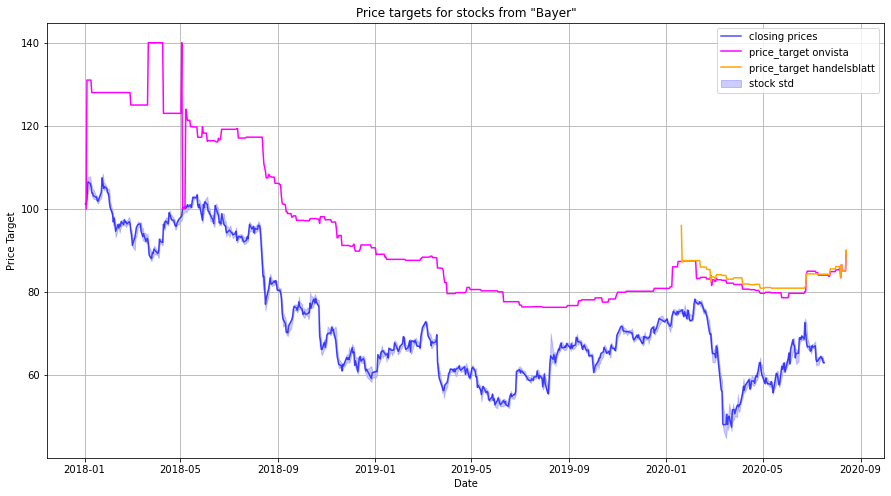

In [49]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.fill_between(stock['formatted_date'], stock['high'],
                stock['low'], color='blue', 
         label='stock std', alpha=0.2)
ax.plot(stock['formatted_date'], stock['close'], color='blue', 
         label='closing prices', alpha=0.7)

ax.plot(onvista_smp['dates'], onvista_smp['price_target'], 
        label='price_target onvista',
        color='magenta')
ax.plot(hblatt_smp['dates'], hblatt_smp['price_target'],
            label='price_target handelsblatt', color='orange')
plt.legend()
plt.grid()
plt.title('Price targets for stocks from "{}"'.format(
    str.capitalize(searchterm)))
plt.xlabel('Date')
plt.ylabel('Price Target')

# Residual between real and target price

In [74]:
residual = pd.merge(onvista_smp, stock, left_on='dates', right_on='formatted_date', how='left')
residual['diff'] = residual.price_target - residual.close
residual['diff'] = residual['diff'].fillna(method='ffill')

(736697.0, 737651.0)

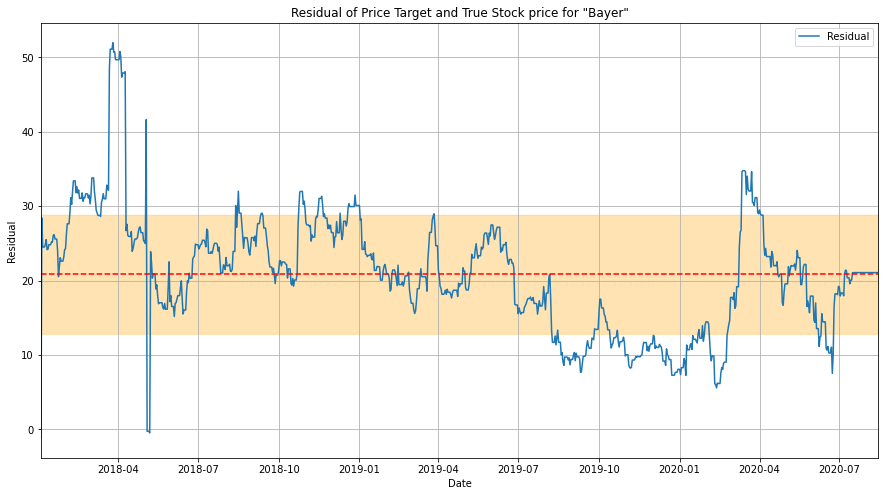

In [75]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(residual['dates'], residual['diff'], label='Residual')

ax.plot(residual['dates'], mvalues, ls='--', color='r')
mvalues = np.array([residual['diff'].mean()]*len(tmp))
svalues = np.array([residual['diff'].std()]*len(tmp))
ax.fill_between(residual['dates'],
                 mvalues + svalues,
                 mvalues - svalues, color='orange', alpha=0.3);
ax.legend()
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
ax.set_title('Residual of Price Target and True Stock price for "{}"'.format(str.capitalize(searchterm)))
ax.set_xlim([residual['dates'].min(), residual['dates'].max()])